# Evn

In [27]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as KK

from tqdm.notebook import tqdm

In [28]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [29]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Config

In [30]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [31]:
# config 생성
# d_model: model hidden dim
# n_head: multi head attention head number
# d_head: multi head attention head dim
# dropout: dropout rate
# d_ff: feed forward dim
# norm_eps: layernormal epsilon
# n_layer: layer number
# n_seq: sequence max number
# n_vocab: vocab count
# i_pad: vocab pad id
config = Config({"d_model": 8,
                 "n_head": 2,
                 "d_head": 4,
                 "dropout": 0.1,
                 "d_ff": 32,
                 "norm_eps": 0.001,
                 "n_layer": 6,
                 "n_seq": 16,
                 "n_vocab": 16,
                 "i_pad": 0})
config

{'d_ff': 32,
 'd_head': 4,
 'd_model': 8,
 'dropout': 0.1,
 'i_pad': 0,
 'n_head': 2,
 'n_layer': 6,
 'n_seq': 16,
 'n_vocab': 16,
 'norm_eps': 0.001}

# Input

In [32]:
# 입력 문장
sentences = [
    ['나는 오늘 행복해', '나도 기분이 좋아'],
    # ['나는 오늘 기분이 좋아', '나도 매우 행복하다'],
]

In [33]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 8,
  '나는': 4,
  '나도': 7,
  '오늘': 5,
  '좋아': 9,
  '행복해': 6},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '행복해',
  7: '나도',
  8: '기분이',
  9: '좋아'})

In [34]:
# Question과 Answer를 숫자료
question_list, answer_list = [], []

for pair in sentences:
    question_list.append([word_to_id[word] for word in pair[0].split()])
    answer_list.append([word_to_id[word] for word in pair[1].split()])

# 학습용 입력 데이터 생성
train_enc_inputs, train_dec_inputs, train_labels = [], [], []
for question, answer in zip(question_list, answer_list):
    train_enc_inputs.append(question)
    train_dec_inputs.append([word_to_id['[BOS]']] + answer)
    train_labels.append(answer + [word_to_id['[EOS]']])

# Encoder 입력의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# Decoder 입력의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_inputs:
    row += [0] * (6 - len(row))

# 정답의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_labels:
    row += [0] * (6 - len(row))

# numpy array로 변환/
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_labels = np.array(train_labels)

train_enc_inputs, train_dec_inputs, train_labels

(array([[4, 5, 6, 0]]),
 array([[2, 7, 8, 9, 0, 0]]),
 array([[7, 8, 9, 3, 0, 0]]))

In [35]:
# embedding with random weight
embed_weight = np.random.randint(-9, 10, (config.n_vocab, config.d_model)) / 10

embed = tf.keras.layers.Embedding(config.n_vocab, config.d_model, weights=[embed_weight])
embed_weight

array([[ 0.6, -0.3,  0.3,  0.6,  0.8,  0. ,  0.2,  0.3],
       [ 0.7, -0.4,  0.7,  0. ,  0.6,  0.9,  0.7,  0.3],
       [-0.4, -0.7, -0.3, -0.6, -0.2,  0.2, -0.9,  0. ],
       [ 0.2,  0.7, -0.6, -0.7,  0.3, -0.8,  0.2,  0.2],
       [ 0.8,  0.5, -0.2,  0.1,  0.2,  0.5,  0.8,  0.4],
       [-0.9,  0.3, -0.4,  0.8, -0.4,  0.4,  0.7,  0. ],
       [-0.1,  0.3, -0.3,  0.3,  0.6,  0.8,  0.9,  0.5],
       [-0.7, -0.4,  0.4, -0.3, -0.2, -0.5, -0.6, -0.4],
       [ 0.5,  0.6,  0.6,  0.6, -0.7,  0.1, -0.5,  0.9],
       [-0.2,  0.2,  0.5,  0.9,  0. , -0.9, -0.7, -0.8],
       [ 0.9,  0.8, -0.2, -0.5, -0.2,  0.8, -0.9,  0. ],
       [ 0.9,  0. , -0.8,  0.5, -0.6,  0.3,  0. ,  0.4],
       [-0.9, -0.5, -0.5, -0.9, -0.1,  0.3,  0.8,  0. ],
       [ 0.6, -0.1, -0.7,  0.7,  0.2, -0.7,  0.9,  0.6],
       [-0.6,  0.5, -0.7, -0.5, -0.8,  0.1, -0.7,  0.4],
       [-0.6,  0.9,  0.3, -0.4,  0.8,  0.7, -0.1,  0.4]])

In [36]:
# encoder hidden
hidden_enc = embed(train_enc_inputs)
hidden_enc

<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[ 0.8,  0.5, -0.2,  0.1,  0.2,  0.5,  0.8,  0.4],
        [-0.9,  0.3, -0.4,  0.8, -0.4,  0.4,  0.7,  0. ],
        [-0.1,  0.3, -0.3,  0.3,  0.6,  0.8,  0.9,  0.5],
        [ 0.6, -0.3,  0.3,  0.6,  0.8,  0. ,  0.2,  0.3]]], dtype=float32)>

In [37]:
# decoder hidden
hidden_dec = embed(train_dec_inputs)
hidden_dec

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[-0.4, -0.7, -0.3, -0.6, -0.2,  0.2, -0.9,  0. ],
        [-0.7, -0.4,  0.4, -0.3, -0.2, -0.5, -0.6, -0.4],
        [ 0.5,  0.6,  0.6,  0.6, -0.7,  0.1, -0.5,  0.9],
        [-0.2,  0.2,  0.5,  0.9,  0. , -0.9, -0.7, -0.8],
        [ 0.6, -0.3,  0.3,  0.6,  0.8,  0. ,  0.2,  0.3],
        [ 0.6, -0.3,  0.3,  0.6,  0.8,  0. ,  0.2,  0.3]]], dtype=float32)>

# Mask

## PAD Mask

In [38]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    #########################################
    # 0인 부분 확인
    mask = tf.math.equal(tokens, i_pad)
    # boolean -> float 32
    mask = tf.cast(mask, tf.float32)
    # expand dimension for n_seq
    mask = tf.expand_dims(mask, axis=1)
    #########################################
    return mask

In [39]:
enc_pad_mask = get_pad_mask(train_enc_inputs)
enc_pad_mask

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0., 0., 0., 1.]]], dtype=float32)>

## Causal Mask

In [40]:
def get_causal_mask(tokens, i_pad=0):
    """
    causal mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: causal and pad mask (causal or pad: 1, other: 0)
    """
    #########################################
    # 개수 조회
    n_seq = tf.shape(tokens)[1]
    # print(n_seq)
    # make ahead mask
    mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    # expand dim for bs
    mask = tf.expand_dims(mask, axis=0)
    # get pad_mask
    pad_mask = get_pad_mask(tokens, i_pad)
    # mask all ahead_mask or pad_mask
    mask = tf.maximum(mask, pad_mask)
    #########################################
    return mask

In [41]:
dec_causal_mask = get_causal_mask(train_dec_inputs)
dec_causal_mask

<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.]]], dtype=float32)>

## Mask 생성

In [42]:
# Encoder Self Attetnion mask
enc_self_mask = get_pad_mask(train_enc_inputs)
enc_self_mask

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0., 0., 0., 1.]]], dtype=float32)>

In [43]:
# Decoder Self Attetnion mask
dec_self_mask = get_causal_mask(train_dec_inputs)
dec_self_mask

<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.]]], dtype=float32)>

In [44]:
# Encoder-Decoder Attetnion mask
enc_dec_mask = get_pad_mask(train_enc_inputs)
enc_dec_mask

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0., 0., 0., 1.]]], dtype=float32)>

# Scaled dot product attention

In [45]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        #########################################
        Q, K, V, attn_mask = inputs
        # matmul Q, K (transpose_b=True)
        attn_score = tf.matmul(Q, K, transpose_b=True)
        # get scale = d_model ** 0.5
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        print(attn_score)
        # divide by scale
        attn_scale = tf.math.divide(attn_score, scale)
        print(attn_scale)
        # do mask (subtract 1e-9 for masked value)
        attn_scale -= 1.e9 * attn_mask
        print(attn_scale)
        # calculate attention prob
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        print(attn_prob)
        # weighted sum of V
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
        #########################################

In [46]:
# Encoder Self Attetnion
Q = hidden_enc
K = hidden_enc
V = hidden_enc

attention = ScaleDotProductAttention()
attn_out = attention((Q, K, V, enc_self_mask))
attn_out

tf.Tensor(
[[[ 2.0300002   0.27000004  1.6         0.7700001 ]
  [ 0.27000004  2.51        1.25       -0.45000002]
  [ 1.6         1.25        2.3400002   0.75      ]
  [ 0.7700001  -0.45000002  0.75        1.6700001 ]]], shape=(1, 4, 4), dtype=float32)
tf.Tensor(
[[[ 0.7177135   0.09545943  0.56568545  0.27223614]
  [ 0.09545943  0.88741904  0.44194174 -0.15909903]
  [ 0.56568545  0.44194174  0.827315    0.26516506]
  [ 0.27223614 -0.15909903  0.26516506  0.5904342 ]]], shape=(1, 4, 4), dtype=float32)
tf.Tensor(
[[[ 7.1771348e-01  9.5459431e-02  5.6568545e-01 -1.0000000e+09]
  [ 9.5459431e-02  8.8741904e-01  4.4194174e-01 -1.0000000e+09]
  [ 5.6568545e-01  4.4194174e-01  8.2731497e-01 -1.0000000e+09]
  [ 2.7223614e-01 -1.5909903e-01  2.6516506e-01 -1.0000000e+09]]], shape=(1, 4, 4), dtype=float32)
tf.Tensor(
[[[0.41741496 0.2240405  0.3585445  0.        ]
  [0.21636577 0.47767472 0.3059595  0.        ]
  [0.3142034  0.27763212 0.40816444 0.        ]
  [0.3784159  0.24583454 0.37574953

<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[ 0.09644109,  0.383483  , -0.28066254,  0.32853726,
          0.2089935 ,  0.5851593 ,  0.8134504 ,  0.34623826],
        [-0.28741056,  0.34327316, -0.3261309 ,  0.4955642 ,
          0.03577897,  0.54402035,  0.78282845,  0.23952606],
        [-0.0393226 ,  0.36284065, -0.29634288,  0.37597537,
          0.1966865 ,  0.5946861 ,  0.81305325,  0.3297636 ],
        [ 0.0439067 ,  0.3756832 , -0.28674185,  0.3472341 ,
          0.2027991 ,  0.5881414 ,  0.8129915 ,  0.33924115]]],
      dtype=float32)>

In [47]:
# Decoder Self Attetnion
Q = hidden_dec
K = hidden_dec
V = hidden_dec

attn_out = attention((Q, K, V, dec_self_mask))
attn_out

tf.Tensor(
[[[ 1.99        1.1        -0.5500001  -0.30000007 -0.82000005
   -0.82000005]
  [ 1.1         1.71       -0.5         1.18       -0.76000005
   -0.76000005]
  [-0.5500001  -0.5         2.8899999   0.40000007  0.27000004
    0.27000004]
  [-0.30000007  1.18        0.40000007  3.08        0.13000001
    0.13000001]
  [-0.82000005 -0.76000005  0.27000004  0.13000001  1.6700001
    1.6700001 ]
  [-0.82000005 -0.76000005  0.27000004  0.13000001  1.6700001
    1.6700001 ]]], shape=(1, 6, 6), dtype=float32)
tf.Tensor(
[[[ 0.70357126  0.38890874 -0.19445439 -0.10606604 -0.2899138
   -0.2899138 ]
  [ 0.38890874  0.60457635 -0.17677669  0.417193   -0.2687006
   -0.2687006 ]
  [-0.19445439 -0.17677669  1.0217693   0.14142138  0.09545943
    0.09545943]
  [-0.10606604  0.417193    0.14142138  1.0889444   0.04596195
    0.04596195]
  [-0.2899138  -0.2687006   0.09545943  0.04596195  0.5904342
    0.5904342 ]
  [-0.2899138  -0.2687006   0.09545943  0.04596195  0.5904342
    0.5904342 ]]]

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[-0.4       , -0.7       , -0.3       , -0.6       ,
         -0.2       ,  0.2       , -0.9       ,  0.        ],
        [-0.56611264, -0.5338873 ,  0.08759624, -0.43388736,
         -0.20000002, -0.18759623, -0.7338873 , -0.22148357],
        [ 0.10658358,  0.17015487,  0.39534226,  0.20757583,
         -0.51289505,  0.00528992, -0.5930563 ,  0.48770767],
        [-0.22024184,  0.00745238,  0.38439474,  0.3624162 ,
         -0.19720611, -0.47977903, -0.6690711 , -0.2977426 ],
        [-0.13489893,  0.01090932,  0.3456014 ,  0.2524991 ,
         -0.29308322, -0.29094657, -0.6598884 , -0.04186693],
        [-0.13489893,  0.01090932,  0.3456014 ,  0.2524991 ,
         -0.29308322, -0.29094657, -0.6598884 , -0.04186693]]],
      dtype=float32)>

In [48]:
# Encoder-Decoder Attetnion
Q = hidden_dec
K = hidden_enc
V = hidden_enc

attn_out = attention((Q, K, V, enc_dec_mask))
attn_out

tf.Tensor(
[[[-1.3299999  -0.68000007 -1.03       -0.82000005]
  [-1.8000002  -0.43       -1.52       -0.76000005]
  [ 0.51000005 -0.05999994 -0.21000004  0.27000004]
  [-1.4        -0.09       -1.55        0.13000001]
  [ 0.7700001  -0.45000002  0.75        1.6700001 ]
  [ 0.7700001  -0.45000002  0.75        1.6700001 ]]], shape=(1, 6, 4), dtype=float32)
tf.Tensor(
[[[-0.470226   -0.24041633 -0.36416    -0.2899138 ]
  [-0.63639617 -0.15202796 -0.53740114 -0.2687006 ]
  [ 0.18031225 -0.02121318 -0.07424623  0.09545943]
  [-0.49497473 -0.03181981 -0.5480077   0.04596195]
  [ 0.27223614 -0.15909903  0.26516506  0.5904342 ]
  [ 0.27223614 -0.15909903  0.26516506  0.5904342 ]]], shape=(1, 6, 4), dtype=float32)
tf.Tensor(
[[[-4.7022599e-01 -2.4041633e-01 -3.6416000e-01 -1.0000000e+09]
  [-6.3639617e-01 -1.5202796e-01 -5.3740114e-01 -1.0000000e+09]
  [ 1.8031225e-01 -2.1213183e-02 -7.4246228e-02 -1.0000000e+09]
  [-4.9497473e-01 -3.1819806e-02 -5.4800773e-01 -1.0000000e+09]
  [ 2.7223614e-01

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[-0.13165584,  0.35934266, -0.30766588,  0.42734352,
          0.10794224,  0.561637  ,  0.7956541 ,  0.28364244],
        [-0.20692162,  0.35365948, -0.31671894,  0.4640838 ,
          0.05719477,  0.54531634,  0.7860731 ,  0.25542712],
        [-0.00511441,  0.37713844, -0.29296046,  0.3805099 ,
          0.13042648,  0.5581737 ,  0.79837143,  0.30378246],
        [-0.20495296,  0.35653827, -0.31665277,  0.4680712 ,
          0.03770465,  0.53550506,  0.7818871 ,  0.24712145],
        [ 0.0439067 ,  0.3756832 , -0.28674185,  0.3472341 ,
          0.2027991 ,  0.5881414 ,  0.8129915 ,  0.33924115],
        [ 0.0439067 ,  0.3756832 , -0.28674185,  0.3472341 ,
          0.2027991 ,  0.5881414 ,  0.8129915 ,  0.33924115]]],
      dtype=float32)>

# Multi Head Attention

In [49]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        #########################################
        Q, K, V, attn_mask = inputs
        # Q_m = self.W_Q(Q)
        # print(Q_m.shape)
        # Q_m = tf.reshape(Q_m, [-1, tf.shape(Q)[1], self.n_head, self.d_head])
        # print(Q_m.shape)
        # Q_m = tf.transpose(Q_m, [0, 2, 1, 3])
        # print(Q_m.shape)
        # build multihead Q, K, V
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [-1, tf.shape(Q)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [-1, tf.shape(K)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [-1, tf.shape(V)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        # print(Q_m.shape, K_m.shape, V_m.shape)÷
        # build multihead mask
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # print(attn_mask.shape, attn_mask_m.shape)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out_m = self.attention((Q_m, K_m, V_m, attn_mask_m))  # (bs, n_head, Q_len, d_head)
        print(attn_out_m.shape)
        # transpose and reshape
        attn_out_t = tf.transpose(attn_out_m, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        print(attn_out_t.shape)
        attn_out_c = tf.reshape(attn_out_t, [-1, tf.shape(Q)[1], config.n_head * config.d_head])  # (bs, Q_len, n_head * d_head)
        print(attn_out_c.shape)
        # linear for output
        attn_out = self.W_O(attn_out_c) # (bs, Q_len, d_model)
        return attn_out
        #########################################

In [50]:
# Encoder Self Attetnion
Q = hidden_enc
K = hidden_enc
V = hidden_enc

attention = MultiHeadAttention(config)
attn_out = attention((Q, K, V, enc_self_mask))
attn_out

tf.Tensor(
[[[[ 0.4313012  -0.8966237   0.02190087  0.1764947 ]
   [-0.08729167 -0.53734285 -0.1568726   0.12410032]
   [ 0.77178    -0.8935663   0.20822093  0.14456144]
   [ 0.446103   -0.54315645  0.13342643  0.06203743]]

  [[ 0.24614017  0.36679795  0.11196789 -0.16239204]
   [-0.25534546  0.15774152  0.11491045 -0.74029636]
   [ 0.1244552   0.04023616 -0.08651809  0.07063328]
   [ 0.2787341   0.2585806   0.20187484  0.44904995]]]], shape=(1, 2, 4, 4), dtype=float32)
tf.Tensor(
[[[[ 0.2156506  -0.44831184  0.01095044  0.08824735]
   [-0.04364583 -0.26867142 -0.0784363   0.06205016]
   [ 0.38589    -0.44678316  0.10411046  0.07228072]
   [ 0.2230515  -0.27157822  0.06671321  0.03101872]]

  [[ 0.12307008  0.18339898  0.05598395 -0.08119602]
   [-0.12767273  0.07887076  0.05745522 -0.37014818]
   [ 0.0622276   0.02011808 -0.04325905  0.03531664]
   [ 0.13936704  0.1292903   0.10093742  0.22452497]]]], shape=(1, 2, 4, 4), dtype=float32)
tf.Tensor(
[[[[ 2.15650603e-01 -4.48311836e-01  

<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[ 0.43471104,  0.44572398,  0.5391537 ,  0.23079449,
         -0.44174948,  0.6911439 , -0.5490895 ,  0.6467725 ],
        [ 0.51149946,  0.451175  ,  0.4848386 ,  0.27802506,
         -0.42976496,  0.6627286 , -0.5844399 ,  0.678738  ],
        [ 0.40119967,  0.44520247,  0.5794236 ,  0.22617167,
         -0.44534248,  0.7113391 , -0.5498792 ,  0.64006567],
        [ 0.45474035,  0.4491846 ,  0.54184955,  0.2672256 ,
         -0.43547893,  0.6941123 , -0.57822526,  0.6630997 ]]],
      dtype=float32)>

In [51]:
# Decoder Self Attetnion
Q = hidden_dec
K = hidden_dec
V = hidden_dec

attn_out = attention((Q, K, V, dec_self_mask))
attn_out

tf.Tensor(
[[[[-0.22348303  0.23751095 -1.1013607   0.44177264 -0.12119554
    -0.12119554]
   [-0.4672251   0.1838243  -1.4623797   0.6549793  -0.16873904
    -0.16873904]
   [ 0.38590297  1.1288346  -1.5709016   1.2403735   0.02247436
     0.02247436]
   [-0.00450798  0.56933427 -1.1371938   0.8764032  -0.05454347
    -0.05454347]
   [ 0.20406924 -0.3571753   1.3443182  -0.6219016   0.06203743
     0.06203743]
   [ 0.20406924 -0.3571753   1.3443182  -0.6219016   0.06203743
     0.06203743]]

  [[-0.05701034  0.09708103 -0.03433508  1.1053865   0.347591
     0.347591  ]
   [-0.04530432  0.09694293 -0.53265786 -0.06698688  0.20539254
     0.20539254]
   [ 0.9315053   0.37054163 -0.85728616 -1.9088722  -1.1058707
    -1.1058707 ]
   [ 0.7319032   0.46771282 -1.5942025  -1.8299404  -0.6463093
    -0.6463093 ]
   [-0.57460874 -0.3151669   0.58781826  0.5172224   0.44904995
     0.44904995]
   [-0.57460874 -0.3151669   0.58781826  0.5172224   0.44904995
     0.44904995]]]], shape=(1, 2, 6,

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.0891695 , -0.34438148, -0.33358446, -0.10471538,
         -0.16308282,  0.2822656 ,  0.41895556, -0.37422764],
        [ 0.17599739, -0.51975965, -0.78391093, -0.06180657,
          0.31736463, -0.5291899 ,  0.534712  , -0.49347398],
        [ 0.29478788, -0.5416267 , -0.65238506, -0.02967224,
          0.2437666 , -0.487518  ,  0.44446772, -0.3608341 ],
        [ 0.14655975, -0.53837943, -0.7355577 , -0.10129623,
          0.44888204, -0.86581266,  0.43535393, -0.42014894],
        [ 0.22779873, -0.34364387, -0.8348546 , -0.22844957,
          0.06489427, -0.5794691 ,  0.3062088 , -0.20685902],
        [ 0.22779873, -0.34364387, -0.8348546 , -0.22844957,
          0.06489427, -0.5794691 ,  0.3062088 , -0.20685902]]],
      dtype=float32)>

In [52]:
# Encoder-Decoder Attetnion
Q = hidden_dec
K = hidden_enc
V = hidden_enc

attn_out = attention((Q, K, V, enc_dec_mask))
attn_out

tf.Tensor(
[[[[-0.30468163  0.5673056   0.00148163 -0.12119554]
   [-0.27506608  0.8639508   0.032642   -0.16873904]
   [-1.3381431   0.2685243  -0.6353104   0.02247436]
   [-0.7096291   0.44117096 -0.29979903 -0.05454347]
   [ 0.446103   -0.54315645  0.13342643  0.06203743]
   [ 0.446103   -0.54315645  0.13342643  0.06203743]]

  [[-0.19792919 -1.1294165  -0.80364573  0.347591  ]
   [-0.17637263 -0.08410779  0.04038366  0.20539254]
   [-0.13603605  0.5909887   0.48579454 -1.1058707 ]
   [-0.38511276  0.450917    0.5409357  -0.6463093 ]
   [ 0.2787341   0.2585806   0.20187484  0.44904995]
   [ 0.2787341   0.2585806   0.20187484  0.44904995]]]], shape=(1, 2, 6, 4), dtype=float32)
tf.Tensor(
[[[[-0.15234081  0.2836528   0.00074082 -0.06059777]
   [-0.13753304  0.4319754   0.016321   -0.08436952]
   [-0.66907156  0.13426214 -0.3176552   0.01123718]
   [-0.35481456  0.22058548 -0.14989951 -0.02727173]
   [ 0.2230515  -0.27157822  0.06671321  0.03101872]
   [ 0.2230515  -0.27157822  0.06671

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.5792575 ,  0.4649462 ,  0.50666   ,  0.46492878,
         -0.38866478,  0.6811368 , -0.7171974 ,  0.74375427],
        [ 0.6325451 ,  0.4622575 ,  0.4186465 ,  0.41474074,
         -0.38696676,  0.6196067 , -0.6771912 ,  0.74133074],
        [ 0.689003  ,  0.46169406,  0.33987018,  0.40022868,
         -0.3843616 ,  0.5770035 , -0.66006035,  0.7469231 ],
        [ 0.6531169 ,  0.4601613 ,  0.37633675,  0.37224534,
         -0.39432007,  0.5938588 , -0.6473211 ,  0.73547566],
        [ 0.45474035,  0.4491846 ,  0.54184955,  0.2672256 ,
         -0.43547893,  0.6941123 , -0.57822526,  0.6630997 ],
        [ 0.45474035,  0.4491846 ,  0.54184955,  0.2672256 ,
         -0.43547893,  0.6941123 , -0.57822526,  0.6630997 ]]],
      dtype=float32)>

# Feed Forward

In [53]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=tf.nn.relu)
        self.W_2 = tf.keras.layers.Dense(config.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        # linear W_1 and W_2
        ff_val = self.W_1(inputs)
        ff_val = self.W_2(ff_val)
        return ff_val

In [54]:
# feed-forward class 동작 확인
feed_forward = PositionWiseFeedForward(config)
ff_val = feed_forward(hidden_enc)
ff_val.shape

TensorShape([1, 4, 8])

# LayerNormal
- https://arxiv.org/abs/1607.06450

In [55]:
# 큰 hidden 생성
hidden = np.array([[1, 2, 3],
                   [11, 11, 13],
                   [111, 122, 133]]).astype(np.float32)
hidden

array([[  1.,   2.,   3.],
       [ 11.,  11.,  13.],
       [111., 122., 133.]], dtype=float32)

In [56]:
# layer_normal 실행
layer_norm = tf.keras.layers.LayerNormalization()
layer_norm(hidden)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-1.2238274 ,  0.        ,  1.2238274 ],
       [-0.70670974, -0.70670974,  1.4134184 ],
       [-1.2247372 ,  0.        ,  1.2247372 ]], dtype=float32)>

In [57]:
# weights
layer_norm.get_weights()

[array([1., 1., 1.], dtype=float32), array([0., 0., 0.], dtype=float32)]

In [58]:
# 평균 값
mean = np.mean(hidden, axis=-1, keepdims=True)
mean

array([[  2.      ],
       [ 11.666667],
       [122.      ]], dtype=float32)

In [59]:
# sqrt(var - epsiolo)
sigma = np.sqrt(np.var(hidden, axis=-1, keepdims=True) + 0.001)
sigma

array([[0.81710875],
       [0.9433392 ],
       [8.981518  ]], dtype=float32)

In [60]:
# layer normal 계산
(hidden - mean) / sigma

array([[-1.2238274,  0.       ,  1.2238274],
       [-0.7067097, -0.7067097,  1.4134184],
       [-1.2247373,  0.       ,  1.2247373]], dtype=float32)

# Encoder Layer

In [61]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name='encoder_layer'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, inputs):
        """
        layer 실행
        :param inputs: enc_hidden, self_mask tuple
        :return enc_out: EncoderLayer 실행 결과
        """
        enc_hidden, self_mask = inputs
        # self attention
        self_attn_val = self.self_attention((enc_hidden, enc_hidden, enc_hidden, self_mask))
        # add and layer normal
        norm1_val = self.norm1(enc_hidden + self.dropout(self_attn_val))
        
        # feed forward
        ffn_val = self.ffn(norm1_val)
        # add and layer normal
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [62]:
# EncoderLayer 기능 확인
encoder_layer = EncoderLayer(config)
enc_out = encoder_layer((hidden_enc, enc_self_mask))
enc_out.shape

tf.Tensor(
[[[[ 0.5255724  -0.07470232  0.27639183 -0.1819105 ]
   [ 0.28577515  0.49413067  0.8647398  -0.38555267]
   [ 0.92754084  0.36180478  1.0434064  -0.5708286 ]
   [ 0.6284573  -0.20016025  0.20129803 -0.13162914]]

  [[ 0.15275669 -0.23656234  0.12136088  0.02080625]
   [-0.51511383 -1.582393    0.36928642  0.48038173]
   [-0.55697244 -0.4724375   0.1017852   0.0019303 ]
   [ 0.13668045  0.7911482  -0.26683146 -0.6786793 ]]]], shape=(1, 2, 4, 4), dtype=float32)
tf.Tensor(
[[[[ 0.2627862  -0.03735116  0.13819592 -0.09095525]
   [ 0.14288758  0.24706534  0.4323699  -0.19277634]
   [ 0.46377042  0.18090239  0.5217032  -0.2854143 ]
   [ 0.31422865 -0.10008013  0.10064901 -0.06581457]]

  [[ 0.07637835 -0.11828117  0.06068044  0.01040313]
   [-0.25755692 -0.7911965   0.18464321  0.24019086]
   [-0.27848622 -0.23621875  0.0508926   0.00096515]
   [ 0.06834023  0.3955741  -0.13341573 -0.33933964]]]], shape=(1, 2, 4, 4), dtype=float32)
tf.Tensor(
[[[[ 2.62786210e-01 -3.73511575e-02  

TensorShape([1, 4, 8])

# Decoder Layer

In [63]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    Decoder Layer Class
    """
    def __init__(self, config, name='decoder_layer'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.ende_attn = MultiHeadAttention(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.ffn = PositionWiseFeedForward(config)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=config.norm_eps)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: dec_hidden, enc_out, self_mask, ende_mask tuple
        :return dec_out: DecoderLayer 실행 결과
        """
        dec_hidden, enc_out, self_mask, ende_mask = inputs
        # self attention
        self_attn_val = self.self_attention((dec_hidden, dec_hidden, dec_hidden, self_mask))
        # add and layer normal
        norm1_val = self.norm1(dec_hidden + self.dropout(self_attn_val))

        # encoder and decoder attention
        ende_attn_val = self.ende_attn((norm1_val, enc_out, enc_out, ende_mask))
        # add and layer normal
        norm2_val = self.norm2(norm1_val + self.dropout(ende_attn_val))

        # feed forward
        ffn_val = self.ffn(norm2_val)
        # add and layer normal
        dec_out = self.norm3(norm2_val + self.dropout(ffn_val))

        return dec_out

In [64]:
# Decoder 실행
decoder_layer = DecoderLayer(config)
dec_out = decoder_layer((hidden_dec, hidden_enc, dec_self_mask, enc_dec_mask))
dec_out.shape

tf.Tensor(
[[[[-0.11671825 -1.2317492  -0.49207485 -1.907551    0.28353286
     0.28353286]
   [-0.59449714 -1.2881643  -0.5231718  -1.590177    0.5324288
     0.5324288 ]
   [-0.19842885  0.2360975   0.13382775  0.590487    0.08082158
     0.08082158]
   [-0.5959471  -0.05069627  0.26960802  0.68310136  0.46734872
     0.46734872]
   [ 0.5544742   1.1085641   0.49821994  1.4083637  -0.50359374
    -0.50359374]
   [ 0.5544742   1.1085641   0.49821994  1.4083637  -0.50359374
    -0.50359374]]

  [[-0.39257494 -0.0417034  -0.01557479  0.17762949  0.29531205
     0.29531205]
   [-0.10676157 -0.04822192  0.08109175  0.09515648  0.10955238
     0.10955238]
   [ 0.42169914 -0.11682875  0.0918733  -0.20224944 -0.22264418
    -0.22264418]
   [ 0.58068     0.02579629 -0.06052849 -0.5264168  -0.4398529
    -0.4398529 ]
   [ 0.7295858   0.40333894 -0.69290435 -1.1402042  -0.8320168
    -0.8320168 ]
   [ 0.7295858   0.40333894 -0.69290435 -1.1402042  -0.8320168
    -0.8320168 ]]]], shape=(1, 2, 6,

TensorShape([1, 6, 8])

# Weight Shared Embedding

In [65]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name='weight_shared_embedding'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope('shared_embedding_weight'):
            self.shared_weights = self.add_weight(
                'weights',
                shape=[self.n_vocab, self.d_model],
                initializer=tf.keras.initializers.TruncatedNormal(stddev=self.d_model ** -0.5)
            )

    def call(self, inputs, mode='embedding'):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == 'embedding':
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == 'linear':
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f'mode {mode} is not valid.')
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        # lookup by gather
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        # muliply d_model ** 0.5
        embed *= self.d_model ** 0.5
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        # matmul inputs, shared_weights (transpose_b=True)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        return outputs

In [66]:
embedding = SharedEmbedding(config)
hidden_dec = embedding(train_dec_inputs)
hidden_dec.shape

TensorShape([1, 6, 8])

In [67]:
linear_outputs = embedding(hidden_dec, mode="linear")
linear_outputs.shape

TensorShape([1, 6, 16])

# Postional Encoding

In [68]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name='position_embedding'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        pos_encoding = PositionalEmbedding.get_sinusoid_encoding(config.n_seq, config.d_model)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, trainable=False, weights=[pos_encoding])

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        # make position (0...n_seq)
        position = tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True)
        position = tf.cast(position, tf.int32)
        # embedding lookup
        embed = self.embedding(position)
        return embed

    @staticmethod
    def get_sinusoid_encoding(n_seq, d_model):
        """
        sinusoid encoding 생성
        :param n_seq: sequence number
        :param n_seq: model hidden dimension
        :return: positional encoding table
        """
        # calculate angle
        exs = [2 * (i_ang // 2) / d_model for i_ang in range(d_model)]
        angles = [np.power(10000, ex) for ex in exs]
        # calculate position
        pos_encoding = np.array([[pos / angle for angle in angles] for pos in range(n_seq)])
        # sin even number
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        # cos odd number
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.cast(pos_encoding, tf.float32)

In [69]:
# position encoding 확인
pos_encoding = PositionalEmbedding.get_sinusoid_encoding(4, 4)
pos_encoding

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147096,  0.5403023 ,  0.00999983,  0.99995   ],
       [ 0.9092974 , -0.41614684,  0.01999867,  0.9998    ],
       [ 0.14112   , -0.9899925 ,  0.0299955 ,  0.99955004]],
      dtype=float32)>

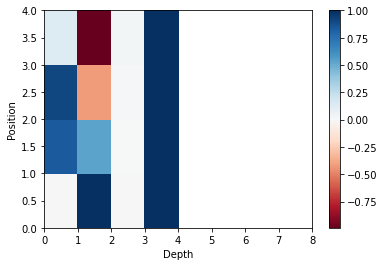

In [70]:
# display
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, config.d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [71]:
# PositionalEmbedding 클래스 시험
pos_embedding = PositionalEmbedding(config)
dec_pos = pos_embedding(train_enc_inputs)
dec_pos.shape

TensorShape([1, 4, 8])

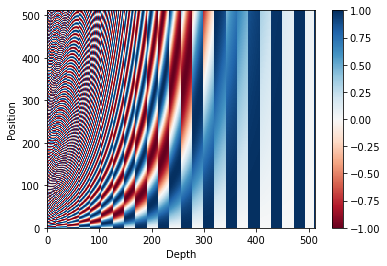

In [72]:
# 512x512 position encoding table 생성
pos_encoding = PositionalEmbedding.get_sinusoid_encoding(512, 512)
# display
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Transformer

In [74]:
class Transformer(tf.keras.Model):
    """
    Transformer Class
    """
    def __init__(self, config, name='transformer'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        
        self.encoder_layers = [EncoderLayer(config, name=f'encoder_layer_{i}') for i in range(config.n_layer)]
        self.decoder_layers = [DecoderLayer(config, name=f'decoder_layer_{i}') for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: enc_tokens, dec_tokens tuple
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, dec_tokens = inputs
        # encoder self attention mask
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)
        # decoder self attention mask
        dec_self_mask = get_causal_mask(dec_tokens, self.i_pad)
        # encoder and decoder attention mask
        enc_dec_mask = get_pad_mask(enc_tokens, self.i_pad)

        # enc_tokens, dec_tokens embedding lookup
        enc_embed = self.get_embedding(enc_tokens)
        dec_embed = self.get_embedding(dec_tokens)

        #########################################
        # dropout for enc_embed
        enc_hidden = self.dropout(enc_embed)
        # call encoder layers
        for encoder_layer in self.encoder_layers:
            enc_hidden = encoder_layer((enc_hidden, enc_self_mask))
        
        # dropout for dec_embed
        dec_hidden = self.dropout(dec_embed)
        # call decoder layers
        for decoder_layer in self.decoder_layers:
            dec_hidden = decoder_layer((dec_hidden, enc_hidden, dec_self_mask, enc_dec_mask))
        #########################################

        # call weight shared embedding (model=linear)
        logits = self.embedding(dec_hidden, mode='linear')
        return logits
    
    def get_embedding(self, tokens):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens)
        return embed

In [75]:
# Transformer 기능 확인. 최종 결과가 (bs, n_seq(dec), n_vocab)
transformer = Transformer(config)
logits = transformer((train_enc_inputs, train_dec_inputs))
logits.shape

tf.Tensor(
[[[[ 0.39553094  1.4666034  -0.17475076 -0.73700136]
   [-0.17463778 -3.099339    3.6557114   3.096045  ]
   [-1.6372342  -1.7748023  -4.398244   -2.601997  ]
   [-1.3795726   3.5990965  -0.19756141 -2.1871808 ]]

  [[ 0.5408247   2.511286    0.94815     0.37414527]
   [-0.04379059 -2.1370802  -0.4268151   0.7580019 ]
   [ 1.7493452   0.6605009   1.11103     1.828699  ]
   [ 1.4802158   3.3189833   3.217893    2.091978  ]]]], shape=(1, 2, 4, 4), dtype=float32)
tf.Tensor(
[[[[ 0.19776547  0.7333017  -0.08737538 -0.36850068]
   [-0.08731889 -1.5496695   1.8278557   1.5480225 ]
   [-0.8186171  -0.88740116 -2.199122   -1.3009984 ]
   [-0.6897863   1.7995483  -0.09878071 -1.0935904 ]]

  [[ 0.27041236  1.255643    0.474075    0.18707263]
   [-0.0218953  -1.0685401  -0.21340755  0.37900096]
   [ 0.8746726   0.33025044  0.555515    0.9143495 ]
   [ 0.7401079   1.6594917   1.6089464   1.045989  ]]]], shape=(1, 2, 4, 4), dtype=float32)
tf.Tensor(
[[[[ 1.9776547e-01  7.3330170e-01 -8.

TensorShape([1, 6, 16])